#Эксперименты с «Преступлением и наказанием»

In [0]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [0]:
url = 'https://rvb.ru/dostoevski/01text/vol5/27.htm'
r = requests.get(url)
r.encoding = 'utf-8'
soup = BeautifulSoup(r.content)

Парсим текст романа с rvb.ru. Спасибо РВБ за разметку строк!

In [0]:
text1 = []
t = soup.find('p', class_='text-regular').text
i = 1
a = None
for all in soup.findAll('p'):
  if all.get('class')[0] == 'text-continuation':
    if a is not None:
      a = a + ' ' + all.text
    else:
      a =  t + ' ' + all.text
      t = None
  elif all.get('class')[0] == 'text-regular':
    if a is not None:
      text1.append([a, i])
      a = None
    if t is not None:
      text1.append([t, i])
    t = all.text
    i = all['id']

Сколько строк в ПиН

In [0]:
len(text1)

3758

Записываем прямую речь из романа в файл (подготовка для разметки).

In [0]:
j = []
for all in text1:
  if all[0].startswith('— ') or '«' in all[0]:
    t = {}
    t['text'] = all[0]
    t['id'] = all[1]
    j.append(t)

In [0]:
with open('dostnew.txt', 'w', encoding = 'utf-8') as f:
  for all in j:
    f.write(all['text'])
    f.write('\r\n')

#Соединяем разметку с текстом.

Изымаем размеченные фразы из импортированного из doccano файла.

In [0]:
with open('pin.json1', 'r', encoding = 'utf-8') as f:
  text = f.read()
text = text.split('\n')
sent = []
for all in text:
  a = json.dumps(all)
  b = json.loads(a)
  sent.append(b)
sent = sent[:-1]

Превращаем список строк в словарь с id строк.

In [0]:
text1 = text1[1:]
text2 = {}
for all in text1:
  i = int(all[1][1:])
  text2[i] = all[0]

In [0]:
sent1 = []
for all in sent:
  sent1.append(json.loads(all))

Генерируем новый словарь: строки и их Id из текста романа, labels из импортированного файла.

In [0]:
new = []
for k, v in text2.items():
  d = {}
  d['id'] = k
  d['text'] = text2[k]
  for all in sent1:
    if all['text'] == text2[k]:
      d['labels'] = all['labels']
  new.append(d)

#Строим графики речи персонажей

In [0]:
labels = {}
for all in new:
  if 'labels' in all.keys():
    for l in all['labels']:
      if l[2] in labels.keys():
        labels[l[2]] += (l[1] - l[0])
      else:
        labels[l[2]] = (l[1] - l[0])

In [0]:
# в разметке поручик Порох и письмоводитель Заметов случайно распались на двух персонажей, сводим их вместе
new_labels = {}
new_labels['Порох'] = labels['Порох'] + labels['поручик']
new_labels['Заметов'] = labels['Заметов'] + labels['письмоводитель']

In [0]:
# достаточно произвольное деление персонажей романа на людей и именованных персонажей
peoples = ['артельщик', 'городовой', 'дворник', 'люди', 'мещанин', 'молодой парень в красной рубахе',
           'молодой человек', 'отец', 'офицер', 'студент', 'Кох', 'старуха-процентщица', 
           'Луиза Ивановна', 'Амалия Ивановна', 'священник', 'Поленька']
a = 0
for all in peoples:
  a += labels[all]
new_labels['люди'] = a

In [0]:
persons = ['Дуня', 'Зосимов', 'Катерина Ивановна', 'Лебезятников', 'Лизавета', 'Лужин',
           'Мармеладов', 'Микола', 'Настасья', 'Никодим Фомич', 'Порфирий Петрович',
           'Пульхерия Александровна', 'Разумихин', 'Раскольников', 'Свидригайлов', 'Соня']
for all in persons:
  new_labels[all] = labels[all]

Рисуем график длины речей каждого персонажа в буквах

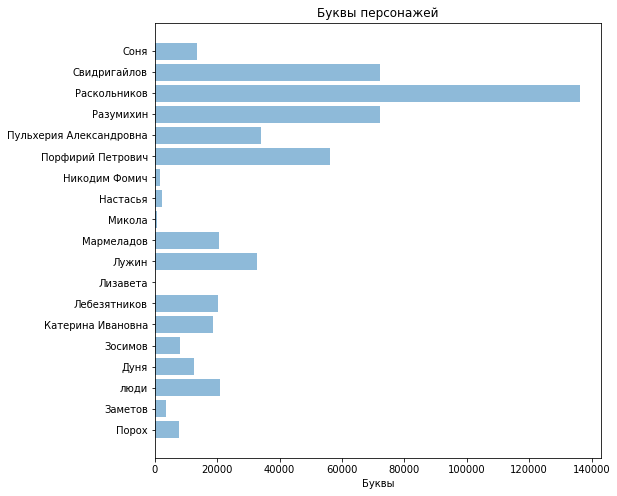

In [0]:
import matplotlib.pyplot as plt
import numpy as np

objects = new_labels.keys()
y_pos = np.arange(len(objects))
performance = [new_labels[key] for key in new_labels.keys()]
plt.figure(figsize=(8,8))
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Буквы')
plt.title('Буквы персонажей')

plt.show()

In [0]:
# считаем речи персонажей последовательно для каждых n строк (в данном случае n = 300)
all_labels = []
test_labels = {}
for name in new_labels.keys():
  test_labels[name] = 0
for all in new:
  if new.index(all) % 300 == 0:
    all_labels.append(test_labels)
    test_labels = {}
    for name in new_labels.keys():
      test_labels[name] = 0
  if 'labels' in all.keys():
    for x in all['labels']:
      if x[2] in peoples:
        test_labels['люди'] += x[1] - x[0]
      elif x[2] == 'письмоводитель':
        test_labels['Заметов'] += x[1] - x[0]
      elif x[2] == 'поручик':
        test_labels['Порох'] += x[1] - x[0]
      elif x[2] == "глагол":
        pass
      else:
        test_labels[x[2]] += x[1] - x[0]
all_labels.append(test_labels)

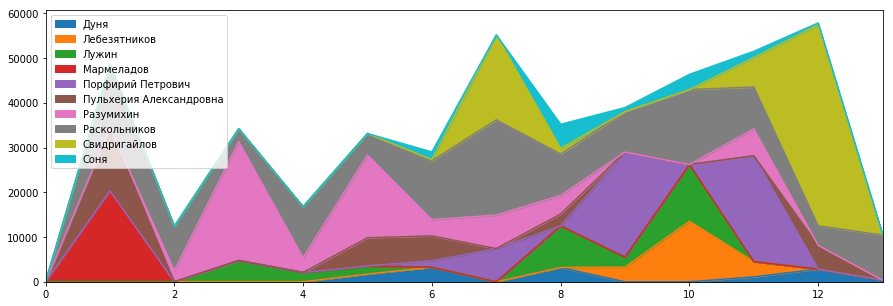

In [0]:
df = pd.DataFrame.from_records(all_labels)
exclude = ['Микола', 'Лизавета', 'Никодим Фомич', 'Настасья', 'Заметов', 'Порох', 'Зосимов', 'люди', 'Катерина Ивановна']
df.loc[:, df.columns.difference(exclude)].plot.area(figsize = (15, 5), stacked=True)

#Громкость в романе (в речи персонажей)

Собираем по тексту все глаголы, вводящие прямую речь

In [0]:
verbs = []
for all in range(len(sent1)):
  for l in sent1[all]['labels']:
    if l[2] == 'глагол':
      v = sent1[all]['text'][l[0]:l[1]]
      verbs.append(v.strip())
print(len(verbs)) # количество глаголов, вводящих прямую речь
verbs = sorted(set(verbs))
print(len(verbs)) # количество уникальных глаголов, вводящих прямую речь

1628
222


In [0]:
print(*verbs)

бормотал бормотала брякнул брякнула ввернул ввязался взвизгнул взвизгнула взволновалась вздрогнул вздумалось вмешалась вмешался возразил возразила вопила воскликнул воскликнула восклицал восклицала вскинулась вскрикивает вскрикнул вскрикнула вскричал вскричала всплеснула вспомнил вспыхнул вспыхнула встревожилась встрепенулся вступилась всхлипывает вцепился выговорил выкрикивал выкрикивала выл вырвалось вырвался высказала говорил говорила говорили говорит горячился догадался додумывался дрогнул дрожал думал думала думалось завопил завопила заговорил заговорила загорячился заключил заключила закричал закричала закудахтал заметил заметила замолчал замямлил заплакала заревел засмеялся затараторила заторопилась заторопился захихикал захохотал зашептал зашептала заявил звала испугался кивнул крикнул крикнула кричал кричала кричали кричат кричит лепетала мелькало мелькнула мелькнуло металась молил настаивал настаивала начал начала обернулся обиделся оборотился обратилась обратился осведомился

Делим глаголы на тихий, громкие и нейтральные (громкие можно еще поделить на очень громкие и просто громкие).

In [0]:
#быстро или громко
word_plus = ['взвизгнул',  'взвизгнула',  'взволновалась', 'вопила',
 'воскликнул', 'воскликнула', 'восклицал', 'восклицала', 'вскинулась',
 'вскрикивает', 'вскрикнул', 'вскрикнула', 'вскричал', 'вскричала',
 'всплеснула', 'вспыхнул', 'вспыхнула', 'встревожилась',
 'выкрикивал', 'выкрикивала', 'выл', 'горячился',
 'завопил', 'завопила', 'загорячился', 'закричал', 'закричала', 'закудахтал', 'заревел',
 'засмеялся', 'затараторила', 'заторопилась', 'заторопился',
 'захихикал', 'захохотал',
 'крикнул', 'крикнула', 'кричал', 'кричала', 'кричали', 'кричат', 'кричит',
 'металась', 'отрезал', 'отрезала',
 'перебил', 'перебила', 'поспешил', 'поспешила', 'причитал',
 'прокричал', 'проревел',
 'разгорячился', 'раздражался', 'разливался', 'рассмеялся',
 'скрежетал', 'смеялась', 'смеялся',
 'сыпал', 'торопила', 'торопилась', 'торопился',
 'умоляла', 'хохочут']

In [0]:
# тихо
word_minus = ['бормотал', 'бормотала',  'всхлипывает',
 'замямлил', 'заплакала',
 'зашептал', 'зашептала', 'лепетала',
 'пробормотал', 'пробормотала', 'пробормотать', 'проворчал', 'промямлил',
 'процедил', 'трепетал',
 'шепнул', 'шепнула', 'шептал', 'шептала', 'прошептал', 'прошептала']

In [0]:
word_neutral = []
for all in verbs:
  if all not in word_plus and all not in word_minus:
    word_neutral.append(all)

In [0]:
print(*word_neutral)

брякнул брякнула ввернул ввязался вздрогнул вздумалось вмешалась вмешался возразил возразила вспомнил встрепенулся вступилась вцепился выговорил вырвалось вырвался высказала говорил говорила говорили говорит догадался додумывался дрогнул дрожал думал думала думалось заговорил заговорила заключил заключила заметил заметила замолчал заявил звала испугался кивнул мелькало мелькнула мелькнуло молил настаивал настаивала начал начала обернулся обиделся оборотился обратилась обратился осведомился остановил ответил ответила отвечал отвечала отговорился отмахивался отозвалась отозвался отпарировал переговорил перепугалась перервал переспросил переспросила писала повторил повторила повторял повторяла поддакивал поддакивала поддакнул подошел подтвердил подтверждал подумал подумала подумалось подхватил подхватила поправил попросил попросила порешил послышался посмотрела прервал прервала прибавил прибавила прибавляет прицепился проговорил проговорила продолжал продолжала произнес произнесла промель

In [0]:
word_all = []
tempo = {}
def nul_all():
  tempo = {}
  tempo['plus']= 0
  tempo['minus']= 0
  tempo['neutral'] = 0
  return tempo
tempo = nul_all()
for all in range(len(new)):
  if all % 100 == 0:
    word_all.append(tempo)
    tempo = nul_all()
  if 'labels' in new[all].keys():
    for l in new[all]['labels']:
      if 'глагол' in l:
        v = new[all]['text'][l[0]:l[1]]
        if v in word_plus:
          tempo['plus'] +=1
        elif v in word_minus:
          tempo['minus'] += 1
        elif v in word_neutral:
          tempo['neutral'] +=1
word_all.append(tempo)

In [0]:
word_df = pd.DataFrame.from_records(word_all)

In [0]:
word_df['Тихие разговоры'] = word_df['minus'] / (word_df['minus'] + word_df['neutral'] + word_df['plus'])
word_df['Шумные разговоры'] = word_df['plus'] / (word_df['minus'] + word_df['neutral'] + word_df['plus'])
word_df['neutral_pr'] = word_df['neutral'] / (word_df['minus'] + word_df['neutral'] + word_df['plus'])
word_df['result'] = word_df['Шумные разговоры'] - word_df['Тихие разговоры']

Получаем график тихих и громких речей в романе

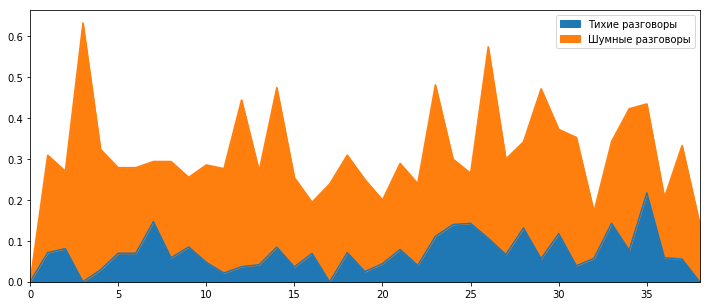

In [0]:
exclude = ['plus', 'minus', 'neutral', 'neutral_pr', 'result']
word_df.loc[:, word_df.columns.difference(exclude)].plot.area(figsize = (12, 5), stacked=True)

Получаем график изменения громкости речей (вычитаем из громких речей тихие речи)


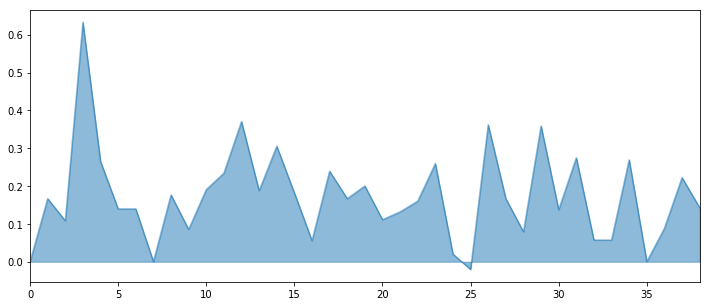

In [0]:
word_df['result'].plot.area(figsize = (12, 5), stacked = False)

#Звуки в романе

«Звуковая» лексика собрана с помощью пакета natasha и ее модели navec, построенной по текстам Либрусека: отталкиваясь от минимального набора «звуковых» слов в несколько итераций собиралась близкая лексика. Потом они нормализованы с помощью pymorphy2 и в нем же составлен список всех словоформ. Теперь будем весь этот список искать в романе.

In [0]:
with open('sounds_form.txt', 'r', encoding='utf-8') as f:
  sounds = f.readlines()
sounds= [all.strip() for all in sounds]
for_sounds = new

In [0]:
import nltk
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

for x in range(len(for_sounds)):
  for_sounds[x]['tokens'] = [all.lower() for all in tokenizer.tokenize(for_sounds[x]['text'])]

In [0]:
import re
def ind(s, token):
  s = s.lower()
  start = [m.start() for m in re.finditer(token, s)]
  if start:
    l = []
    for all in start:
      l.append([all, all+len(token)])
    return l
  else:
    return None

In [0]:
for all in range(len(for_sounds)):
  for x in sounds:
    if x in for_sounds[all]['tokens']:
      spans = ind(for_sounds[all]['text'], x)
      if spans:
        for span in spans:
          s = (span[0], span[1], 'sound')
          if 'sounds' in for_sounds[all].keys():
            for_sounds[all]['sounds'].append(span)
          else:
            for_sounds[all]['sounds'] = [span]      

# Визуализация разметки звуков в тексте романа

In [0]:
!pip install ipymarkup
from ipymarkup import show_ascii_markup
from ipymarkup import show_line_markup
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, BLUE, RED, GREEN

In [0]:
for all in range(230, 250):
  if 'sounds' in for_sounds[all].keys():
    show_box_markup(for_sounds[all]['text'], for_sounds[all]['sounds'], palette=palette(BLUE))
  else:
    print(for_sounds[all]['text'])

Два парня из толпы достают еще по кнуту и бегут к лошаденке сечь ее с боков. Каждый бежит с своей стороны.


BoxMarkup('— По морде ее, по глазам хлещи, по глазам! — кричит Миколка.',
          [Span(45, 51, None)])

BoxMarkup('— Песню, братцы! — кричит кто-то с телеги, и все в телеге подхватывают. Раздается разгульная песня, брякает бубен, в припевах свист. Бабенка щелкает орешки и посмеивается.',
          [Span(2, 7, None),
           Span(19, 25, None),
           Span(72, 81, None),
           Span(93, 98, None),
           Span(100, 107, None),
           Span(117, 125, None),
           Span(126, 131, None),
           Span(158, 170, None)])

BoxMarkup('...Он бежит подле лошадки, он забегает вперед, он видит, как ее секут по глазам, по самым глазам! Он плачет. Сердце в нем поднимается, слезы текут. Один из секущих задевает его по лицу; он не чувствует, он ломает свои руки, кричит, бросается к седому старику с седою бородой, который качает головой и осуждает всё это. Одна баба берет его за руку и хочет увесть; но он вырывается и опять бежит к лошадке. Та уже при последних усилиях, но еще раз начинает лягаться.',
          [Span(101, 107, None), Span(224, 230, None)])

BoxMarkup('— А чтобы те леший! — вскрикивает в ярости Миколка. Он бросает кнут, нагибается и вытаскивает со дна телеги длинную и толстую оглоблю, берет ее за конец в обе руки и с усилием размахивается над савраской.',
          [Span(22, 33, None)])

BoxMarkup('— Разразит! — кричат кругом.', [Span(14, 20, None)])

— Убьет!


BoxMarkup('— Мое добро! — кричит Миколка и со всего размаху опускает оглоблю. Раздается тяжелый удар.',
          [Span(15, 21, None), Span(67, 76, None)])

BoxMarkup('— Секи ее, секи! Что стали! — кричат голоса из толпы.',
          [Span(30, 36, None), Span(37, 43, None)])

BoxMarkup('А Миколка намахивается в другой раз, и другой удар со всего размаху ложится на спину несчастной клячи. Она вся оседает всем задом, но вспрыгивает и дергает, дергает из всех последних сил в разные стороны, чтобы вывезти; но со всех сторон принимают ее в шесть кнутов, а оглобля снова вздымается и падает в третий раз, потом в четвертый, мерно, с размаха. Миколка в бешенстве, что не может с одного удара убить.',
          [Span(336, 341, None)])

BoxMarkup('— Живуча! — кричат кругом.', [Span(12, 18, None)])

BoxMarkup('— Сейчас беспременно падет, братцы, тут ей и конец! — кричит из толпы один любитель.',
          [Span(54, 60, None)])

BoxMarkup('— Топором ее, чего! Покончить с ней разом, — кричит третий.',
          [Span(45, 51, None)])

BoxMarkup('— Эх, ешь те комары! Расступись! — неистово вскрикивает Миколка, бросает оглоблю, снова нагибается в телегу и вытаскивает железный лом. — Берегись! — кричит он и что есть силы огорошивает с размаху свою бедную лошаденку. Удар рухнул; кобыленка зашаталась, осела, хотела было дернуть, но лом снова со всего размаху ложится ей на спину, и она падает на землю, точно ей подсекли все четыре ноги разом.',
          [Span(2, 4, None), Span(44, 55, None), Span(150, 156, None)])

BoxMarkup('— Добивай! — кричит Миколка и вскакивает, словно себя не помня, с телеги. Несколько парней, тоже красных и пьяных, схватывают что попало — кнуты, палки, оглоблю, и бегут к издыхающей кобыленке. Миколка становится сбоку и начинает бить ломом зря по спине. Кляча протягивает морду, тяжело вздыхает и умирает.',
          [Span(13, 19, None)])

BoxMarkup('— Доконал! — кричат в толпе.', [Span(13, 19, None)])

— А зачем вскачь не шла!


BoxMarkup('— Мое добро! — кричит Миколка, с ломом в руках и с налитыми кровью глазами. Он стоит будто жалея, что уж некого больше бить.',
          [Span(15, 21, None)])

BoxMarkup('— Ну и впрямь, знать, креста на тебе нет! — кричат из толпы уже многие голоса.',
          [Span(44, 50, None), Span(71, 77, None)])

BoxMarkup('Но бедный мальчик уже не помнит себя. С криком пробивается он сквозь толпу к савраске, обхватывает ее мертвую, окровавленную морду и целует ее, целует ее в глаза, в губы... Потом вдруг вскакивает и в исступлении бросается с своими кулачонками на Миколку. В этот миг отец, уже долго гонявшийся за ним, схватывает его наконец и выносит из толпы.',
          [Span(40, 46, None)])

#Деление романа на сцены

Извлекаем из файла РВБ деление на части и главы (еще раз спасибо им за разметку)

In [0]:
parts = []
for tag in soup.find_all("h2"):
    parts.append(int(tag.parent.find('p')['id'][1:]))

In [0]:
chapters = []
a = soup.find_all('div', class_='chapter')
for all in a:
  chapters.append(int(all.p['id'][1:]))

In [0]:
#объединяем части и главы
partition = []
for all in reversed(parts):
  chapters_list = []
  for ch in chapters:
    if ch >= all:
      chapters_list.append(ch)
  for c in chapters_list:
    partition.append([parts.index(all)+1, chapters_list.index(c)+1, c])
    chapters.remove(c)
  parts.pop()

from operator import itemgetter
partition = sorted(partition, key = itemgetter(2))

#Извлекаем количество звуков и разговоров

In [0]:
extract_sounds = []
sum_sounds = {}
sum_sounds['sounds'] = 0
sum_sounds['talks'] = 0
sum_sounds['part'] = 'Ч. ' + str(partition[0][0]) + ', гл. ' + str(partition[0][1])
sum_sounds['lines'] = 0
x = 1
for all in range(len(for_sounds)):
  labels_test = []
  sum_sounds['lines'] += len(for_sounds[all]['text'])
  if all == partition[x][2]:
    extract_sounds.append(sum_sounds)
    print(sum_sounds)
    sum_sounds = {}
    sum_sounds['sounds'] = 0
    sum_sounds['talks'] = 0
    sum_sounds['lines'] = 0
    glava = 'Ч. ' + str(partition[x][0]) + ', гл. ' + str(partition[x][1])
    sum_sounds['part'] = glava
    x += 1
    print(x, glava)
  if 'labels' in for_sounds[all].keys():
    for l in for_sounds[all]['labels']:
      if l[2] != 'глагол':
        sum_sounds['talks'] += l[1] - l[0]
      else:
        labels_test.append([l[0], l[1]])
  if 'sounds' in for_sounds[all].keys():
    for s in for_sounds[all]['sounds']:
      if [s[0], s[1]] not in labels_test:
        sum_sounds['sounds'] += s[1] - s[0]

glava = 'Ч. ' + str(partition[x-1][0]) + ', гл. ' + str(partition[x-1][1])
sum_sounds['part'] = glava
print(x, glava)
extract_sounds.append(sum_sounds)

In [0]:
df = pd.DataFrame.from_records(extract_sounds)

Считаем процент разговоров и звуков в каждой главе от общего количества в романе.

In [0]:
df['sounds_pr'] = df['sounds']/sum(df['sounds'])
df['talks_pr'] = df['talks']/sum(df['talks'])
df['Звуки'] = df['sounds_pr']
df['Разговоры'] = df['talks_pr']

Считаем процент звуков и разговоров построчно.

In [0]:
df['Звуков на строку'] = df['sounds']/df['lines']
df['Разговоров на строку'] = df['talks']/df['lines']

In [0]:
df['test'] = df.index.values.astype(int)

In [0]:
df['all_sounds'] = df['sounds_pr'] + df['talks_pr']

In [0]:
content = ['Визит к старухе', ' Мармеладов', 'Письмо матери', 'Мысли о Дуне и франт', 'Сон Раскольникова о лошади', 'Приготовления', 
 'Убийство', 'Визит в контору', 'Визит к Разумихину', 'Явление Разумихина', 'Зосимов', 'Явление Лужина', 'Трактир', 
 'Смерть Мармеладова', 'Визит матери и сестры', 'Разумихин у матери и сестры', 'Мать и сестра у Раскольникова', 'Соня у Раскольникова',
 'Раскольников у Порфирия', 'Мещанин и сон', 'Явление Свидригайлова', 'Раскольников и Лужин', 'Разговор с матерью и сестрой', 
 'Раскольников у Сони', 'Раскольников у Порфирия', 'Миколка и мещанин', 'Лужин и Соня', 'Поминки', 'Скандал на поминках', 'Признание',
 'Смерть Мармеладовой', 'Раскольников и Разумихин', 'Порфирий у Раскольникова', 'Раскольников у Свидригайлова', 'Рассказ Свидригайлова', 
 'Свидригайлов и Дуня', 'Самоубийство', 'Раскольников у матери', 'Признание', 'Сибирь', 'Соня и Раскольников']

In [0]:
df['content'] = content

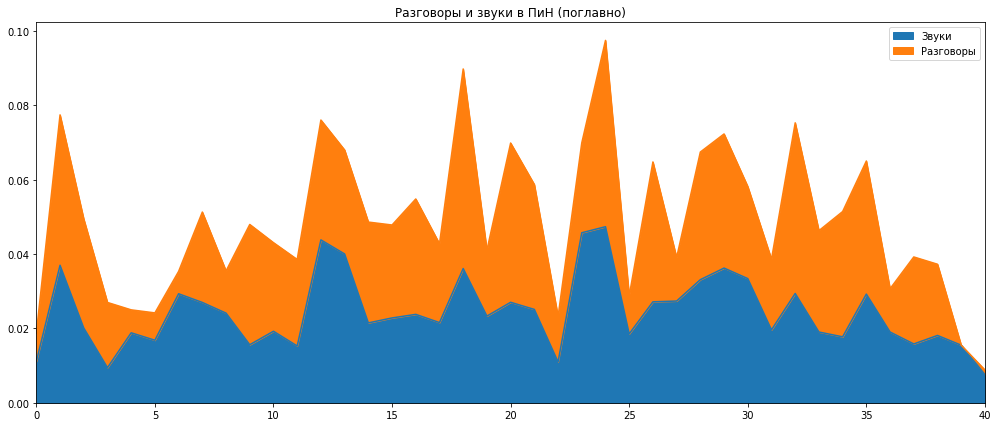

In [0]:
exclude = ['sounds', 'talks', 'talks_pr', 'sounds_pr', 'test', 'all_sounds', 'sounds_lines', 'lines', 'talks_lines', 'Звуков на строку', 'Разговоров на строку']
df.loc[:, df.columns.difference(exclude)].plot.area(figsize = (17, 7), title = 'Разговоры и звуки в ПиН (поглавно)', stacked=True)


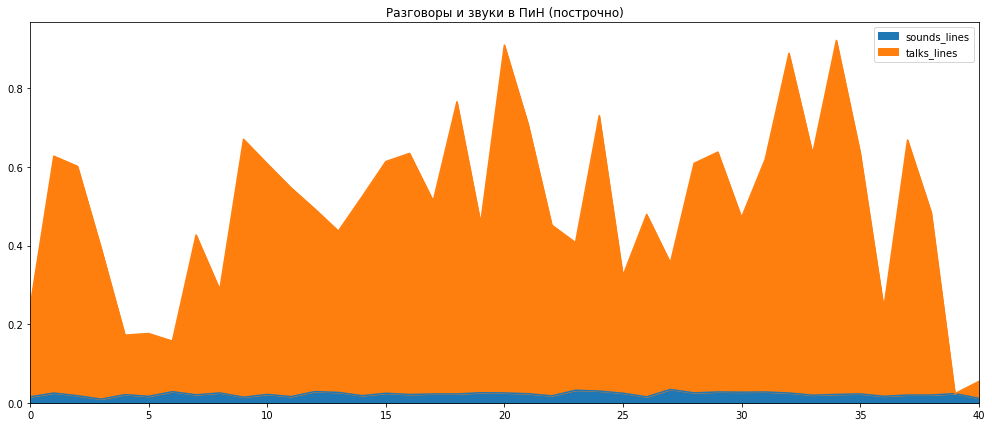

In [0]:
exclude = ['sounds', 'talks', 'talks_pr', 'sounds_pr', 'test', 'all_sounds', 'sounds', 'lines', 'talks', 'Звуки', 'Разговоры']
df.loc[:, df.columns.difference(exclude)].plot.area(figsize = (17, 7), title = 'Разговоры и звуки в ПиН (построчно)', stacked=True)

##Много разговоров

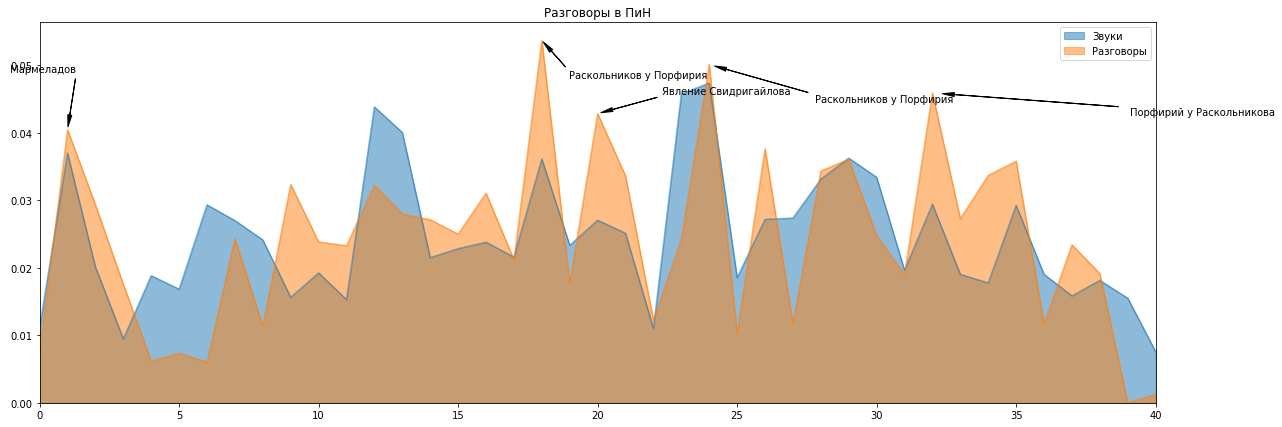

In [0]:
ax = df.loc[:, df.columns.difference(exclude)].plot.area(figsize = (20, 7), title = 'Разговоры в ПиН', stacked=False)
x = 30.5
y = 0.85
for index, row in df.loc[df['talks_pr']>0.04].iterrows():
  ax.annotate(row['content'],
              xy = (row['test'], row['talks_pr']),
              xytext = (row['test']/x, row['talks_pr']+y), textcoords = 'axes fraction',
              arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=4),
              horizontalalignment='right', verticalalignment='top',
              )
  x -= 0.4
  y -= 0.03


##Много звуков

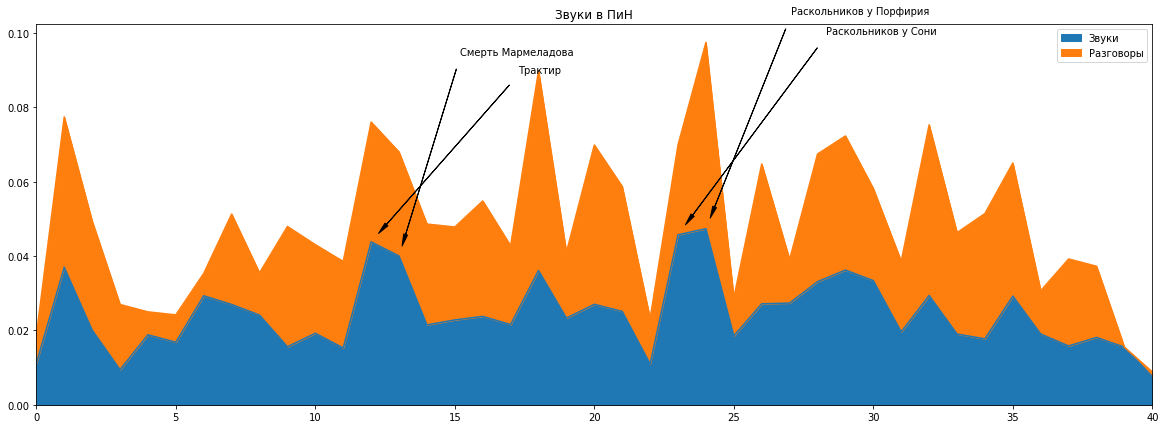

In [0]:
ax = df.loc[:, df.columns.difference(exclude)].plot.area(figsize = (20, 7), title = 'Звуки в ПиН', stacked=True)
x = 0.85
y = 25.5
for index, row in df.loc[df['sounds_pr']>0.04].iterrows():
  ax.annotate(row['content'],
              xy = (row['test'], row['sounds_pr']),
              xytext = (row['test']/y, row['sounds_pr']+x), textcoords = 'axes fraction',
              arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=4),
              horizontalalignment='right', verticalalignment='top',
              )
  x += 0.05
  y += 1.5


##Много и звуков, и разговоров

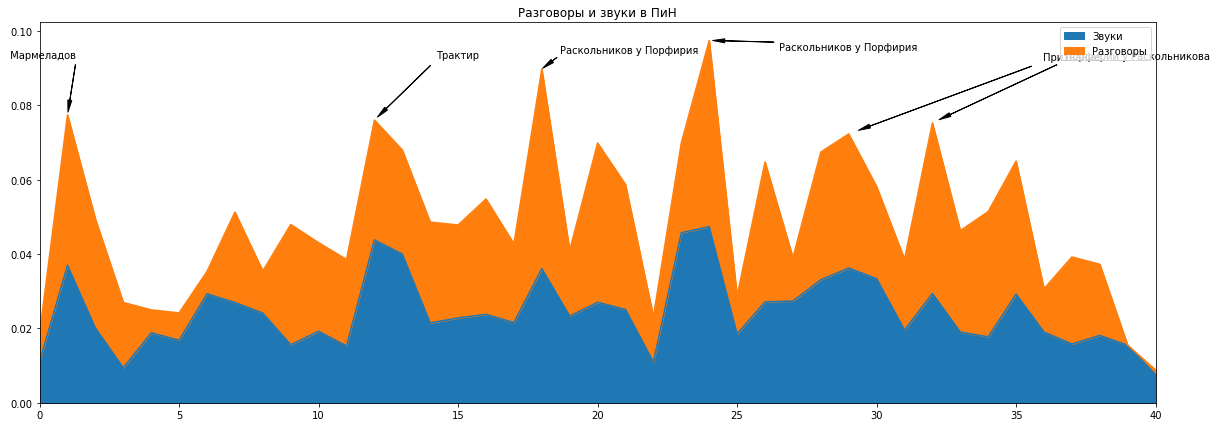

In [0]:
ax = df.loc[:, df.columns.difference(exclude)].plot.area(figsize = (20, 7), title = 'Разговоры и звуки в ПиН', stacked=True)
for index, row in df.loc[df['all_sounds']>0.07].iterrows():
  ax.annotate(row['content'],
              xy = (row['test'], row['all_sounds']),
              xytext = (row['test']/30.5, row['all_sounds']+0.85), textcoords = 'axes fraction',
              arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=4),
              horizontalalignment='right', verticalalignment='top',
              )

# Всякое

##Биграммы в ПиН

In [0]:
sentences = [all['text'] for all in new]

In [0]:
sentences[0]

'В начале июля, в чрезвычайно жаркое время, под вечер, один молодой человек вышел из своей каморки, которую нанимал от жильцов в С — м переулке, на улицу и медленно, как бы в нерешимости, отправился к К — ну мосту.'

In [0]:
import nltk

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
tokenizer = RegexpTokenizer(r'\w+')

sentences_new = []
for all in sentences:
  s = tokenizer.tokenize(all)
  s = [all.lower() for all in s]
  sentences_new.append(s)

In [0]:
text_all[:10]

['в',
 'начале',
 'июля',
 'в',
 'чрезвычайно',
 'жаркое',
 'время',
 'под',
 'вечер',
 'один']

In [0]:
text_all = []
for all in sentences_new:
  text_all.extend(all)

In [0]:
from nltk.collocations import *
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(text_all)

In [0]:
sorted(finder.nbest(trigram_measures.raw_freq, 40))

[('а', 'между', 'тем'),
 ('бы', 'то', 'ни'),
 ('в', 'первый', 'раз'),
 ('в', 'последнее', 'время'),
 ('в', 'самом', 'деле'),
 ('в', 'то', 'же'),
 ('в', 'том', 'что'),
 ('в', 'этом', 'роде'),
 ('в', 'эту', 'минуту'),
 ('во', 'всяком', 'случае'),
 ('да', 'и', 'не'),
 ('до', 'сих', 'пор'),
 ('если', 'б', 'я'),
 ('за', 'то', 'что'),
 ('и', 'без', 'того'),
 ('и', 'как', 'бы'),
 ('и', 'сам', 'не'),
 ('и', 'тотчас', 'же'),
 ('и', 'уж', 'конечно'),
 ('к', 'тому', 'же'),
 ('как', 'бы', 'в'),
 ('может', 'быть', 'и'),
 ('на', 'него', 'и'),
 ('на', 'то', 'что'),
 ('на', 'этот', 'раз'),
 ('не', 'то', 'что'),
 ('несмотря', 'на', 'то'),
 ('ни', 'за', 'что'),
 ('о', 'том', 'что'),
 ('он', 'про', 'себя'),
 ('по', 'крайней', 'мере'),
 ('с', 'каким', 'то'),
 ('стало', 'быть', 'и'),
 ('так', 'и', 'есть'),
 ('то', 'есть', 'не'),
 ('то', 'же', 'время'),
 ('то', 'что', 'я'),
 ('хе', 'хе', 'хе'),
 ('что', 'может', 'быть'),
 ('я', 'может', 'быть')]

In [0]:
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[250:270]

[(('и', 'при', 'этом'), 7),
 (('и', 'проч', 'и'), 7),
 (('и', 'с', 'каким'), 7),
 (('и', 'так', 'как'), 7),
 (('и', 'то', 'что'), 7),
 (('как', 'будто', 'еще'), 7),
 (('как', 'вы', 'думаете'), 7),
 (('как', 'же', 'ты'), 7),
 (('как', 'же', 'это'), 7),
 (('катерина', 'ивановна', 'не'), 7),
 (('крикнула', 'катерина', 'ивановна'), 7),
 (('лицо', 'его', 'было'), 7),
 (('может', 'быть', 'он'), 7),
 (('на', 'всякий', 'случай'), 7),
 (('на', 'том', 'же'), 7),
 (('на', 'ту', 'пору'), 7),
 (('не', 'в', 'бреду'), 7),
 (('ни', 'разу', 'не'), 7),
 (('никак', 'не', 'мог'), 7),
 (('ничего', 'не', 'было'), 7)]

## Разметка прямой речи в тексте: пример

In [0]:
!pip install ipymarkup
from ipymarkup import show_ascii_markup
from ipymarkup import show_line_markup
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, BLUE, RED, GREEN

In [0]:
for all in range(len(new[:20])):
  if 'labels' in new[all].keys():
    show_box_markup(new[all]['text'], new[all]['labels'], palette=palette(BLUE))

BoxMarkup('«На какое дело хочу покуситься и в то же время каких пустяков боюсь! — подумал он с странною улыбкой. — Гм... да... всё в руках человека, и всё-то он мимо носу проносит, единственно от одной трусости... это уж аксиома... Любопытно, чего люди больше всего боятся? Нового шага, нового собственного слова они всего больше боятся... А впрочем, я слишком много болтаю. Оттого и ничего не делаю, что болтаю. Пожалуй, впрочем, и так: оттого болтаю, что ничего не делаю. Это я в этот последний месяц выучился болтать, лежа по целым суткам в углу и думая... о царе Горохе. Ну зачем я теперь иду? Разве я способен на это? Разве это серьезно? Совсем не серьезно. Так, ради фантазии сам себя тешу; игрушки! Да, пожалуй что и игрушки!»',
          [Span(1, 68, 'Раскольников'),
           Span(71, 78, 'глагол'),
           Span(104, 721, 'Раскольников')])

BoxMarkup('Он был до того худо одет, что иной, даже и привычный человек, посовестился бы днем выходить в таких лохмотьях на улицу. Впрочем, квартал был таков, что костюмом здесь было трудно кого-нибудь удивить. Близость Сенной, обилие известных заведений и, по преимуществу, цеховое и ремесленное население, скученное в этих серединных петербургских улицах и переулках, пестрили иногда общую панораму такими субъектами, что странно было бы и удивляться при встрече с иною фигурой. Но столько злобного презрения уже накопилось в душе молодого человека, что, несмотря на всю свою, иногда очень молодую, щекотливость, он менее всего совестился своих лохмотьев на улице. Другое дело при встрече с иными знакомыми или с прежними товарищами, с которыми вообще он не любил встречаться... А между тем, когда один пьяный, которого неизвестно почему и куда провозили в это время по улице в огромной телеге, запряженной огромною ломовою лошадью, крикнул ему вдруг, проезжая: «Эй ты, немецкий шляпник!» — и заорал во всё горло, указывая на него рукой, — молодой человек вдруг остановился и судорожно схватился за свою шляпу. Шляпа эта была высокая, круглая, циммермановская, но вся уже изношенная, совсем рыжая, вся в дырах и пятнах, без полей и самым безобразнейшим углом заломившаяся на сторону. Но не стыд, а совсем другое чувство, похожее даже на испуг, охватило его.',
          [Span(954, 978, 'люди')])

BoxMarkup('«Я так и знал! — бормотал он в смущении, — я так и думал! Это уж всего сквернее! Вот эдакая какая-нибудь глупость, какая-нибудь пошлейшая мелочь, весь замысел может испортить! Да, слишком приметная шляпа... Смешная, потому и приметная... К моим лохмотьям непременно нужна фуражка, хотя бы старый блин какой-нибудь, а не этот урод. Никто таких не носит, за версту заметят, запомнят... главное, потом запомнят, ан и улика. Тут нужно быть как можно неприметнее... Мелочи, мелочи главное!.. Вот эти-то мелочи и губят всегда и всё...»',
          [Span(1, 14, 'Раскольников'),
           Span(17, 25, 'глагол'),
           Span(43, 528, 'Раскольников')])

BoxMarkup('Идти ему было немного; он даже знал, сколько шагов от ворот его дома: ровно семьсот тридцать. Как-то раз он их сосчитал, когда уж очень размечтался. В то время он и сам еще не верил этим мечтам своим и только раздражал себя их безобразною, но соблазнительною дерзостью. Теперь же, месяц спустя, он уже начинал смотреть иначе и, несмотря на все поддразнивающие монологи о собственном бессилии и нерешимости, «безобразную» мечту как-то даже поневоле привык считать уже предприятием, хотя всё еще сам себе не верил. Он даже шел теперь делать пробу своему предприятию, и с каждым шагом волнение его возрастало всё сильнее и сильнее.',
          [])

BoxMarkup('С замиранием сердца и нервною дрожью подошел он к преогромнейшему дому, выходившему одною стеной на канаву, а другою в — ю улицу. Этот дом стоял весь в мелких квартирах и заселен был всякими промышленниками — портными, слесарями, кухарками, разными немцами, девицами, живущими от себя, мелким чиновничеством и проч. Входящие и выходящие так и шмыгали под обоими воротами и на обоих дворах дома. Тут служили три или четыре дворника. Молодой человек был очень доволен, не встретив ни которого из них, и неприметно проскользнул сейчас же из ворот направо на лестницу. Лестница была темная и узкая, «черная», но он всё уже это знал и изучил, и ему вся эта обстановка нравилась: в такой темноте даже и любопытный взгляд был неопасен. «Если о сю пору я так боюсь, что же было бы, если б и действительно как-нибудь случилось до самого дела дойти?..» — подумал он невольно, проходя в четвертый этаж. Здесь загородили ему дорогу отставные солдаты-носильщики, выносившие из одной квартиры мебель. Он уже прежде знал, что в этой квартире жил один семейный немец, чиновник: «Стало быть, этот немец теперь выезжает, и, стало быть, в четвертом этаже, по этой лестнице и на этой площадке, остается, на некоторое время, только одна старухина квартира занятая. Это хорошо... на всякой случай...» — подумал он опять и позвонил в старухину квартиру. Звонок брякнул слабо, как будто был сделан из жести, а не из меди. В подобных мелких квартирах таких домов почти всё такие звонки. Он уже забыл звон этого колокольчика, и теперь этот особенный звон как будто вдруг ему что-то напомнил и ясно представил... Он так и вздрогнул, слишком уже ослабели нервы на этот раз. Немного спустя дверь приотворилась на крошечную щелочку: жилица оглядывала из щели пришедшего с видимым недоверием, и только виднелись ее сверкавшие из темноты глазки. Но увидав на площадке много народу, она ободрилась и отворила совсем. Молодой человек переступил через порог в темную прихожую, разгороженную перегородкой, за которою была крошечная кухня. Старуха стояла перед ним молча и вопросительно на него глядела. Это была крошечная, сухая старушонка, лет шестидесяти, с вострыми и злыми глазками, с маленьким вострым носом и простоволосая. Белобрысые, мало поседевшие волосы ее были жирно смазаны маслом. На ее тонкой и длинной шее, похожей на куриную ногу, было наверчено какое-то фланелевое тряпье, а на плечах, несмотря на жару, болталась вся истрепанная и пожелтелая меховая кацавейка. Старушонка поминутно кашляла и кряхтела. Должно быть, молодой человек взглянул на нее каким-нибудь особенным взглядом, потому что и в ее глазах мелькнула вдруг опять прежняя недоверчивость.',
          [Span(730, 841, 'Раскольников'),
           Span(845, 852, 'глагол'),
           Span(1063, 1277, 'Раскольников'),
           Span(1281, 1288, 'глагол')])

BoxMarkup('— Раскольников, студент, был у вас назад тому месяц, — поспешил пробормотать молодой человек с полупоклоном, вспомнив, что надо быть любезнее.',
          [Span(0, 52, 'Раскольников'), Span(64, 76, 'глагол')])

BoxMarkup('— Помню, батюшка, очень хорошо помню, что вы были, — отчетливо проговорила старушка, по-прежнему не отводя своих вопрошающих глаз от его лица.',
          [Span(0, 50, 'старуха-процентщица'), Span(63, 74, 'глагол')])

BoxMarkup('— Так вот-с... и опять, по такому же дельцу... — продолжал Раскольников, немного смутившись и удивляясь недоверчивости старухи.',
          [Span(0, 46, 'Раскольников'), Span(49, 58, 'глагол')])

BoxMarkup('«Может, впрочем, она и всегда такая, да я в тот раз не заметил», — подумал он с неприятным чувством.',
          [Span(1, 62, 'Раскольников'), Span(67, 74, 'глагол')])

BoxMarkup('— Пройдите, батюшка.', [Span(0, 20, 'старуха-процентщица')])

BoxMarkup('Небольшая комната, в которую прошел молодой человек, с желтыми обоями, геранями и кисейными занавесками на окнах, была в эту минуту ярко освещена заходящим солнцем. «И тогда, стало быть, так же будет солнце светить!..» — как бы невзначай мелькнуло в уме Раскольникова, и быстрым взглядом окинул он всё в комнате, чтобы по возможности изучить и запомнить расположение. Но в комнате не было ничего особенного. Мебель, вся очень старая и из желтого дерева, состояла из дивана с огромною выгнутою деревянною спинкой, круглого стола овальной формы перед диваном, туалета с зеркальцем в простенке, стульев по стенам да двух-трех грошовых картинок в желтых рамках, изображавших немецких барышень с птицами в руках, — вот и вся мебель. В углу перед небольшим образом горела лампада. Всё было очень чисто: и мебель, и полы были оттерты под лоск; всё блестело. «Лизаветина работа», — подумал молодой человек. Ни пылинки нельзя было найти во всей квартире. «Это у злых и старых вдовиц бывает такая чистота», — продолжал про себя Раскольников и с любопытством покосился на ситцевую занавеску перед дверью во вторую, крошечную комнатку, где стояли старухины постель и комод и куда он еще ни разу не заглядывал. Вся квартира состояла из этих двух комнат.',
          [Span(166, 217, 'Раскольников'),
           Span(238, 247, 'глагол'),
           Span(852, 869, 'Раскольников'),
           Span(874, 881, 'глагол'),
           Span(947, 994, 'Раскольников'),
           Span(999, 1008, 'глагол')])

BoxMarkup('— Что угодно? — строго произнесла старушонка, войдя в комнату и по-прежнему становясь прямо перед ним, чтобы глядеть ему прямо в лицо.',
          [Span(0, 13, 'старуха-процентщица'), Span(23, 33, 'глагол')])

BoxMarkup('— Заклад принес, вот-с! — И он вынул из кармана старые плоские серебряные часы. На оборотной дощечке их был изображен глобус. Цепочка была стальная.',
          [Span(0, 23, 'Раскольников')])

BoxMarkup('— Да ведь и прежнему закладу срок. Еще третьего дня месяц как минул.',
          [Span(0, 68, 'старуха-процентщица')])

In [0]:
for all in range(40, 60):
  if 'labels' in new[all].keys():
    show_box_markup(new[all]['text'], new[all]['labels'], palette=palette(BLUE))

BoxMarkup('«О боже! как это всё отвратительно! И неужели, неужели я... нет, это вздор, это нелепость! — прибавил он решительно. — И неужели такой ужас мог прийти мне в голову? На какую грязь способно, однако, мое сердце! Главное: грязно, пакостно, гадко, гадко!.. И я, целый месяц...»',
          [Span(1, 90, 'Раскольников'),
           Span(93, 101, 'глагол'),
           Span(119, 272, 'старуха-процентщица')])

BoxMarkup('Но он не мог выразить ни словами, ни восклицаниями своего волнения. Чувство бесконечного отвращения, начинавшее давить и мутить его сердце еще в то время, как он только шел к старухе, достигло теперь такого размера и так ярко выяснилось, что он не знал, куда деться от тоски своей. Он шел по тротуару как пьяный, не замечая прохожих и сталкиваясь с ними, и опомнился уже в следующей улице. Оглядевшись, он заметил, что стоит подле распивочной, в которую вход был с тротуара по лестнице вниз, в подвальный этаж. Из дверей, как раз в эту минуту, выходили двое пьяных и, друг друга поддерживая и ругая, взбирались на улицу. Долго не думая, Раскольников тотчас же спустился вниз. Никогда до сих пор не входил он в распивочные, но теперь голова его кружилась, и к тому же палящая жажда томила его. Ему захотелось выпить холодного пива, тем более что внезапную слабость свою он относил и к тому, что был голоден. Он уселся в темном и грязном углу, за липким столиком, спросил пива и с жадностию выпил первый стакан. Тотчас же всё отлегло, и мысли его прояснели. «Всё это вздор, — сказал он с надеждой, — и нечем тут было смущаться! Просто физическое расстройство! Один какой-нибудь стакан пива, кусок сухаря, — и вот, в один миг, крепнет ум, яснеет мысль, твердеют намерения! Тьфу, какое всё это ничтожество!..» Но, несмотря на этот презрительный плевок, он глядел уже весело, как будто внезапно освободясь от какого-то ужасного бремени, и дружелюбно окинул глазами присутствующих. Но даже и в эту минуту он отдаленно предчувствовал, что вся эта восприимчивость к лучшему была тоже болезненная.',
          [Span(1057, 1071, 'Раскольников'),
           Span(1074, 1080, 'глагол'),
           Span(1098, 1304, 'Раскольников')])

BoxMarkup('— А осмелюсь ли, милостивый государь мой, обратиться к вам с разговором приличным? Ибо хотя вы и не в значительном виде, но опытность моя отличает в вас человека образованного и к напитку непривычного. Сам всегда уважал образованность, соединенную с сердечными чувствами, и, кроме того, состою титулярным советником. Мармеладов — такая фамилия; титулярный советник. Осмелюсь узнать, служить изволили?',
          [Span(0, 400, 'Мармеладов')])

BoxMarkup('— Нет, учусь... — отвечал молодой человек, отчасти удивленный и особенным витиеватым тоном речи, и тем, что так прямо, в упор, обратились к нему. Несмотря на недавнее мгновенное желание хотя какого бы ни было сообщества с людьми, он при первом, действительно обращенном к нему слове вдруг ощутил свое обычное неприятное и раздражительное чувство отвращения ко всякому чужому лицу, касавшемуся или хотевшему только прикоснуться к его личности.',
          [Span(0, 15, 'Раскольников'), Span(18, 25, 'глагол')])

BoxMarkup('— Студент, стало быть, или бывший студент! — вскричал чиновник, — так я и думал! Опыт, милостивый государь, неоднократный опыт! — и в знак похвальбы он приложил палец ко лбу. — Были студентом или происходили ученую часть! А позвольте... — Он привстал, покачнулся, захватил свою посудинку, стаканчик, и подсел к молодому человеку, несколько от него наискось. Он был хмелен, но говорил речисто и бойко, изредка только местами сбиваясь немного и затягивая речь. С какою-то даже жадностию накинулся он на Раскольникова, точно целый месяц тоже ни с кем не говорил.',
          [Span(0, 42, 'Мармеладов'),
           Span(45, 53, 'глагол'),
           Span(66, 127, 'Мармеладов'),
           Span(177, 236, 'Мармеладов')])

BoxMarkup('— Милостивый государь, — начал он почти с торжественностию, — бедность не порок, это истина. Знаю я, что и пьянство не добродетель, и это тем паче. Но нищета, милостивый государь, нищета — порок-с. В бедности вы еще сохраняете свое благородство врожденных чувств, в нищете же никогда и никто. За нищету даже и не палкой выгоняют, а метлой выметают из компании человеческой, чтобы тем оскорбительнее было; и справедливо, ибо в нищете я первый сам готов оскорблять себя. И отсюда питейное! Милостивый государь, месяц назад тому супругу мою избил господин Лебезятников, а супруга моя не то что я! Понимаете-с? Позвольте еще вас спросить, так, хотя бы в виде простого любопытства: изволили вы ночевать на Неве, на сенных барках?',
          [Span(0, 21, 'Мармеладов'),
           Span(25, 30, 'глагол'),
           Span(62, 724, 'Мармеладов')])

BoxMarkup('— Нет, не случалось, — отвечал Раскольников. — Это что такое?',
          [Span(0, 20, 'Раскольников'),
           Span(23, 30, 'глагол'),
           Span(47, 61, 'Раскольников')])

BoxMarkup('— Ну-с, а я оттуда, и уже пятую ночь-с...',
          [Span(0, 41, 'Мармеладов')])

BoxMarkup('Его разговор, казалось, возбудил общее, хотя и ленивое внимание. Мальчишки за стойкой стали хихикать. Хозяин, кажется, нарочно сошел из верхней комнаты, чтобы послушать «забавника», и сел поодаль, лениво, но важно позевывая. Очевидно, Мармеладов был здесь давно известен. Да и наклонность к витиеватой речи приобрел, вероятно, вследствие привычки к частым кабачным разговорам с различными незнакомцами. Эта привычка обращается у иных пьющих в потребность, и преимущественно у тех из них, с которыми дома обходятся строго и которыми помыкают. Оттого-то в пьющей компании они и стараются всегда как будто выхлопотать себе оправдание, а если можно, то даже и уважение.',
          [])

BoxMarkup('— Забавник! — громко проговорил хозяин. — А для ча не работаешь, для ча не служите, коли чиновник?',
          [Span(0, 11, 'люди'), Span(21, 31, 'глагол'), Span(42, 98, 'люди')])

BoxMarkup('— Для чего я не служу, милостивый государь, — подхватил Мармеладов, исключительно обращаясь к Раскольникову, как будто это он ему задал вопрос, — для чего не служу? А разве сердце у меня не болит о том, что я пресмыкаюсь втуне? Когда господин Лебезятников, тому месяц назад, супругу мою собственноручно избил, а я лежал пьяненькой, разве я не страдал? Позвольте, молодой человек, случалось вам... гм... ну хоть испрашивать денег взаймы безнадежно?',
          [Span(0, 43, 'Мармеладов'),
           Span(46, 55, 'глагол'),
           Span(146, 447, 'Мармеладов')])

BoxMarkup('— Случалось... то есть как безнадежно?',
          [Span(0, 38, 'Раскольников')])

##Извлекаем тексты Раскольникова

In [0]:
rask = []
for all in new:
  if 'labels' in all.keys():
    r = ''
    for l in all['labels']:
      if l[2] == 'Раскольников':
        rask.append(all['text'][l[0]:l[1]])

In [0]:
with open('rask2.txt', 'w', encoding = 'utf-8') as f:
  for all in new:
    f.write(all+'\n')

In [0]:
with open('rask.txt', 'r', encoding = 'utf-8') as f:
  rask = f.readlines()

In [0]:
rask[1]

'На какое дело хочу покуситься и в то же время каких пустяков боюсь!\n'

In [0]:
from nltk.tokenize import sent_tokenize

In [0]:
new = []
for all in rask:
  t = sent_tokenize(all)
  for a in t:
    new.append(a)

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
new[:10]

['Гм... да... всё в руках человека, и всё-то он мимо носу проносит, единственно от одной трусости... это уж аксиома... Любопытно, чего люди больше всего боятся?',
 'Нового шага, нового собственного слова они всего больше боятся... А впрочем, я слишком много болтаю.',
 'Оттого и ничего не делаю, что болтаю.',
 'Пожалуй, впрочем, и так: оттого болтаю, что ничего не делаю.',
 'Это я в этот последний месяц выучился болтать, лежа по целым суткам в углу и думая... о царе Горохе.',
 'Ну зачем я теперь иду?',
 'Разве я способен на это?',
 'Разве это серьезно?',
 'Совсем не серьезно.',
 'Так, ради фантазии сам себя тешу; игрушки!']